In [93]:
import numpy as np
from cvxopt import matrix , solvers
from csv import reader
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [25]:
def read_csv(filename):
    dataset = list()
    data=list()
    lables=list()
    with open(filename, 'r') as file:
        csv_reader = reader(file)
        for row in csv_reader:
            if not row:
                continue
            dataset.append(row)
    dataset.pop(0)
    for rows in dataset:
        lab=rows[0]
        rows.remove(lab)
        lables.append(lab)
        rows = [float(i) for i in rows]
        data.append(rows)
    return data,lables

In [387]:
def create_lables(classes,Y):
    lab=list()
    l=len(classes)
    for i in Y:
        tok=[-1.0 for j in range(l)]
        tok[classes.index(i)]=1.0
        lab.append(tok)
    return lab

In [346]:
def Cfit(x,y):
    Y=np.array(y).T
    X=np.array(x)
    Alphas=list()
    for i in range(numC):
        Alphas.append(fit(X,Y[i]))
    return Alphas

In [347]:
def fit(x,y):
    NUM = x.shape[0]
    DIM = x.shape[1]
    # we'll solve the dual
    # obtain the kernel
    K = y[:, None] * x
    K = np.dot(K, K.T)
    P = matrix(K)
    q = matrix(-np.ones((NUM, 1)))
    G = matrix(-np.eye(NUM))
    h = matrix(np.zeros(NUM))
    A = matrix(y.reshape(1, -1))
    b = matrix(np.zeros(1))
    print('b ', b.size)
    solvers.options['show_progress'] = False
    sol = solvers.qp(P, q, G, h, A, b)
    alphas = np.array(sol['x'])
    return alphas

In [386]:
def Cweight_bias(x1,y1,Alphas):
    Y=np.array(y1).T
    X=np.array(x1)
    WB={}
    for i in range(numC):
        alphas=Alphas[i]
        x=X
        y = Y[i]
        w = np.sum(alphas * y[:, None] * x, axis = 0)
        cond = (alphas > 1e-4).reshape(-1)
        b = y[cond] - np.dot(x[cond], w)
#         print('bias   ',b)
        bias = b[0]
#         print('W ',w)
        norm = np.linalg.norm(w)
#         print('Nor ',norm)
        w= w/norm
        bias= bias / norm
        WB[classes[i]]=w,bias
    return WB

In [363]:
def predict(x,CWB):
    prob=list()
    for i in CWB:
        pro=np.dot(CWB[i][0].T,x)+CWB[i][1]
        prob.append(pro)
    promax=max(prob)
    ind=prob.index(promax)
    return classes[ind]

In [364]:
def all_predict(x,y,CWB):
    numc=0
    numt=0
    for i in range(len(x)):
        numt+=1
        if(y[i]==predict(x[i],CWB)):
            numc+=1
    print(numt)
    print(numc)
    return (numc/numt)*100

------------------TEST-------------------------

In [388]:
a1,b1=read_csv('data/Medical_data.csv')

In [389]:
a=np.array(a1[:2000])

In [390]:
b=np.array(b1[:2000])
b

array(['HEALTHY', 'SURGERY', 'HEALTHY', ..., 'MEDICATION', 'HEALTHY',
       'HEALTHY'], dtype='<U10')

In [391]:
classes=list(set(b))
numC=len(classes)
num=a.shape[0]
dim=a.shape[1]

In [392]:
d=create_lables(classes,b)

In [393]:
d=np.array(d)

In [394]:
e=Cfit(a,d)

b  (1, 1)
b  (1, 1)
b  (1, 1)


In [395]:
WB = Cweight_bias(a,d,e)

In [396]:
WB

{'SURGERY': (array([0.01795518, 0.69532565, 0.71847049]), -1.6664293629894724),
 'HEALTHY': (array([0.89216463, 0.05648623, 0.44816468]), -0.8149914395685337),
 'MEDICATION': (array([ 0.80183238,  0.59523128, -0.05257909]),
  -1.017529884888223)}

In [397]:
a2=np.array(a1[2000:])
b2=np.array(b1[2000:])

In [398]:
print(all_predict(a2,b2,WB))

1000
743
74.3


<bound method Axes3D.plot of <mpl_toolkits.mplot3d.axes3d.Axes3D object at 0x00000133853E9EF0>>

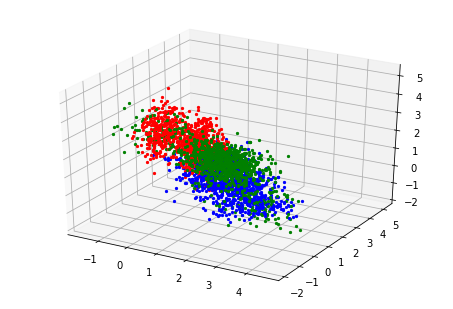

In [98]:
fig = plt.figure()
ax = Axes3D(fig)
for  i in range(len(b)):
    if(b[i]=='HEALTHY'):
        c='g'
    elif(b[i]=='MEDICATION'):
        c='b'
    else :
        c='r'
    ax.scatter(a[i][0],a[i][1],a[i][2],c=c,marker='.')
#     ax.scatter(a[i][0],5,a[i][2],c=c,marker='.')
#     ax.scatter(a[i][0],a[i][1],-2,c=c,marker='.')
ax.plot